# LSTM Model dla prognozowania cen akcji

Ten notebook zawiera implementację modelu LSTM (Long Short-Term Memory) do prognozowania cen akcji.

## 1. Import bibliotek

In [15]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from typing import Dict, List, Tuple, Optional, Union, Any

# Dodanie katalogu głównego do ścieżki
sys.path.append('..')

from src.lstm_model import LSTMModel, LSTMTrainer, prepare_data_for_lstm
from src.utils import (
    create_directories, 
    plot_training_history, 
    plot_predictions, 
    evaluate_model, 
    print_metrics,
    save_model
)

# Ustawienie stylu dla wykresów
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style('whitegrid')

# Sprawdzenie dostępności CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Używane urządzenie: {device}")

# Tworzenie potrzebnych katalogów
create_directories()

ImportError: cannot import name 'LSTMModel' from 'src.lstm_model' (S:\Repos\Projektowanie_i_zastosowania_sieci_neuronowych\src\lstm_model.py)

## 2. Wczytanie danych

In [57]:
data_path = "../data/processed/cleaned_data.csv"

if not os.path.exists(data_path):
    from src.data_preprocessing import preprocess
    df = preprocess()
else:
    df = pd.read_csv(data_path)
    df['Date'] = pd.to_datetime(df['Date'])

print(f"Liczba wierszy w danych: {len(df)}")
df.head()

Liczba wierszy w danych: 2623


C:\Users\pawli\AppData\Local\Temp\ipykernel_4996\606846991.py:8: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


,Date,Open,High,Low,Close/Last,Volume
0,2015-01-02 00:00:00-05:00,172.871004,173.289821,171.028198,172.075241,121465900
1,2015-01-05 00:00:00-05:00,171.019807,171.187332,168.657685,168.967606,169632600
2,2015-01-06 00:00:00-05:00,169.277550,169.805264,166.571994,167.376129,209151400
3,2015-01-07 00:00:00-05:00,168.716328,169.805256,168.264011,169.461823,125346700
4,2015-01-08 00:00:00-05:00,170.885789,172.686711,170.869046,172.468918,147217800


## 3. Dodanie prostych cech technicznych

In [58]:
# Sortowanie
df = df.sort_values('Date').reset_index(drop=True)

# Podstawowe transformacje
df['Returns'] = df['Close/Last'].pct_change()
df['Log_Returns'] = np.log(df['Close/Last'] / df['Close/Last'].shift(1))

# Cechy względne (nie absolutne!)
df['Volume_Ratio'] = df['Volume'] / df['Volume'].rolling(window=10).mean()
df['Daily_Range'] = (df['High'] - df['Low']) / df['Close/Last']
df['Price_Position'] = (df['Close/Last'] - df['Low']) / (df['High'] - df['Low'] + 1e-8)

# Średnie kroczące - jako ratio, nie wartości
df['MA_5'] = df['Close/Last'].rolling(window=5).mean()
df['MA_20'] = df['Close/Last'].rolling(window=20).mean()
df['Price_MA5_Ratio'] = df['Close/Last'] / df['MA_5']
df['Price_MA20_Ratio'] = df['Close/Last'] / df['MA_20']

# Momentum
df['Momentum_5'] = df['Close/Last'] / df['Close/Last'].shift(5) - 1
df['Momentum_10'] = df['Close/Last'] / df['Close/Last'].shift(10) - 1

# Volatility
df['Volatility_5'] = df['Returns'].rolling(window=5).std()
df['Volatility_20'] = df['Returns'].rolling(window=20).std()

# TARGET - następny zwrot!
df['Target_Return'] = df['Returns'].shift(-1)

# Usuń NaN
df = df.dropna()

print(f"Liczba wierszy po dodaniu cech: {len(df)}")
print(f"Nowe cechy: {[col for col in df.columns if col not in ['Date', 'Close/Last', 'Open', 'High', 'Low', 'Volume']]}")


Liczba wierszy po dodaniu cech: 2602
Nowe cechy: ['Returns', 'Log_Returns', 'Volume_Ratio', 'Daily_Range', 'Price_Position', 'MA_5', 'MA_20', 'Price_MA5_Ratio', 'Price_MA20_Ratio', 'Momentum_5', 'Momentum_10', 'Volatility_5', 'Volatility_20', 'Target_Return']


## 4. Przygotowanie danych dla modelu LSTM

In [59]:
# Używaj tylko cech względnych
feature_cols = [
    'Returns',
    'Volume_Ratio',
    'Daily_Range', 
    'Price_Position',
    'Price_MA5_Ratio',
    'Price_MA20_Ratio',
    'Momentum_5',
    'Momentum_10',
    'Volatility_5',
    'Volatility_20'
]

target_col = 'Target_Return'  # ✅ Przewiduj zwroty!

# Przygotowanie danych
data = prepare_data_for_lstm(
    df=df,
    feature_cols=feature_cols,
    target_col=target_col,
    seq_length=30,
    test_size=0.2,
    val_size=0.1,
    batch_size=64,
    shuffle=False   # ✅ Zawsze False dla danych czasowych!
)

print(f"Liczba cech: {data['input_size']}")
print(f"Liczba próbek treningowych: {len(data['X_train'])}")
print(f"Liczba próbek walidacyjnych: {len(data['X_val'])}")
print(f"Liczba próbek testowych: {len(data['X_test'])}")

Liczba cech: 10
Liczba próbek treningowych: 1799
Liczba próbek walidacyjnych: 258
Liczba próbek testowych: 515


## 5. Modyfikacja klasy trenera dla lepszej wydajności

In [60]:
class ImprovedLSTMTrainer(LSTMTrainer):
    """Rozszerzona wersja trenera z lepszymi strategiami."""
    
    def __init__(self, model, learning_rate=0.001, weight_decay=1e-5, device=None):
        super().__init__(model, learning_rate, weight_decay, device)
        
        # Zmiana na Huber Loss - mniej wrażliwy na outliers
        self.criterion = nn.HuberLoss()
        
        # Dodanie schedulera do learning rate
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=5, verbose=True
        )
    
    def train_epoch(self, train_loader):
        """Trenowanie z gradient clipping."""
        self.model.train()
        total_loss = 0
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            
            # Forward pass
            y_pred = self.model(X_batch)
            loss = self.criterion(y_pred, y_batch)
            
            # Backpropagation z gradient clipping
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            total_loss += loss.item()
            
        return total_loss / len(train_loader)
    
    def fit(self, train_loader, val_loader, epochs, early_stopping_patience=10, verbose=True):
        """Trenowanie ze schedulerem."""
        best_val_loss = float('inf')
        epochs_without_improvement = 0
        best_model_state = None
        
        for epoch in range(epochs):
            train_loss = self.train_epoch(train_loader)
            val_loss = self.validate(val_loader)
            
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            
            # Scheduler step
            self.scheduler.step(val_loss)
            
            if verbose and epoch % 10 == 0:
                print(f'Epoka {epoch+1}/{epochs}, Strata treningowa: {train_loss:.6f}, '
                      f'Strata walidacyjna: {val_loss:.6f}')
            
            # Early stopping z zapisem najlepszego modelu
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
                best_model_state = self.model.state_dict().copy()
            else:
                epochs_without_improvement += 1
                
            if epochs_without_improvement >= early_stopping_patience:
                if verbose:
                    print(f'Early stopping po {epoch+1} epokach')
                break
        
        # Przywróć najlepszy model
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)
            
        return {
            'train_loss': self.train_losses,
            'val_loss': self.val_losses
        }

## 6. Definicja ulepszonego modelu LSTM

In [61]:
# Parametry modelu - zwiększone wartości
input_size = data['input_size']
hidden_size = 128  # Zwiększone z 64
num_layers = 4    # Zwiększone z 2
output_size = 1
dropout = 0.3      # Zwiększone z 0.2

# Inicjalizacja modelu
lstm_model = LSTMModel(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
    dropout=dropout
)

lstm_model = lstm_model.to(device)
print(f"Parametry modelu: {sum(p.numel() for p in lstm_model.parameters()):,}")


Parametry modelu: 468,097


## 5. Trenowanie modelu LSTM

In [62]:
# Inicjalizacja ulepszonego trenera
trainer = ImprovedLSTMTrainer(
    model=lstm_model,
    learning_rate=0.0005,  # Zmniejszone z 0.001
    weight_decay=1e-4,     # Zwiększone dla lepszej regularyzacji
    device=device
)

# Parametry trenowania
epochs = 150  # Zwiększone ze 100
early_stopping_patience = 20  # Zwiększone z 15

print("Rozpoczynam trenowanie z ulepszeniami:")
print("- Huber Loss zamiast MSE")
print("- Learning rate scheduler")
print("- Gradient clipping")
print("- Więcej cech technicznych")
print("- Dłuższa sekwencja (30 dni)")

# Trenowanie modelu
history = trainer.fit(
    train_loader=data['train_loader'],
    val_loader=data['val_loader'],
    epochs=epochs,
    early_stopping_patience=early_stopping_patience,
    verbose=True
)

Rozpoczynam trenowanie z ulepszeniami:
- Huber Loss zamiast MSE
- Learning rate scheduler
- Gradient clipping
- Więcej cech technicznych
- Dłuższa sekwencja (30 dni)
Epoka 1/150, Strata treningowa: 0.023614, Strata walidacyjna: 0.002041


c:\Env\Pytorch\PytorchEnv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoka 11/150, Strata treningowa: 0.001674, Strata walidacyjna: 0.001875
Epoka 21/150, Strata treningowa: 0.001628, Strata walidacyjna: 0.001852
Epoka 31/150, Strata treningowa: 0.001648, Strata walidacyjna: 0.001856
Epoka 41/150, Strata treningowa: 0.001604, Strata walidacyjna: 0.001851
Epoka 51/150, Strata treningowa: 0.001563, Strata walidacyjna: 0.001851
Epoka 61/150, Strata treningowa: 0.001601, Strata walidacyjna: 0.001851
Epoka 71/150, Strata treningowa: 0.001583, Strata walidacyjna: 0.001851
Early stopping po 79 epokach


## 6. Analiza wyników treningu

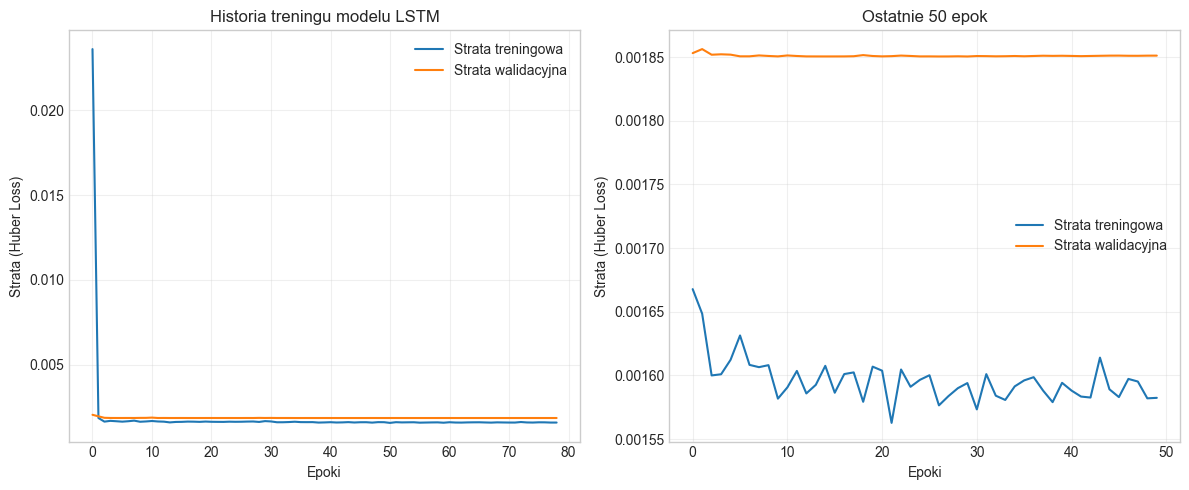

In [ ]:
plt.figure(figsize=(12, 5)) 

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Strata treningowa')
plt.plot(history['val_loss'], label='Strata walidacyjna')
plt.title('Historia treningu modelu LSTM')
plt.xlabel('Epoki')
plt.ylabel('Strata (Huber Loss)')
plt.legend()
plt.grid(True, alpha=0.3)

# Zoom na ostatnie 50 epok
plt.subplot(1, 2, 2)
if len(history['train_loss']) > 50:
    plt.plot(history['train_loss'][-50:], label='Strata treningowa')
    plt.plot(history['val_loss'][-50:], label='Strata walidacyjna')
    plt.title('Ostatnie 50 epok')
    plt.xlabel('Epoki')
    plt.ylabel('Strata (Huber Loss)')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Predykcja na zbiorze testowym

In [64]:
y_pred_returns = trainer.predict(data['X_test'])

# Denormalizacja zwrotów
y_test_returns = data['target_scaler'].inverse_transform(data['y_test'])
y_pred_returns = data['target_scaler'].inverse_transform(y_pred_returns)

# Oblicz metryki na zwrotach
from sklearn.metrics import mean_squared_error, r2_score
r2_returns = r2_score(y_test_returns, y_pred_returns)
mse_returns = mean_squared_error(y_test_returns, y_pred_returns)

print("\n=== METRYKI NA ZWROTACH ===")
print(f"R² na zwrotach: {r2_returns:.4f}")
print(f"MSE na zwrotach: {mse_returns:.6f}")

# Dokładność kierunku (ważna metryka!)
actual_direction = (y_test_returns > 0).astype(int)
pred_direction = (y_pred_returns > 0).astype(int)
direction_accuracy = (actual_direction == pred_direction).mean()
print(f"Dokładność przewidywania kierunku: {direction_accuracy:.1%}")

# Konwersja zwrotów na ceny dla wizualizacji
# Znajdź indeks początkowy dla zbioru testowego
test_start_idx = int(len(df) * 0.7)  # 70% train, 10% val, 20% test
test_df = df.iloc[test_start_idx + int(len(df) * 0.1):]  # Pomijamy validation

# Pobierz rzeczywiste ceny
actual_prices = test_df['Close/Last'].values[30:]  # 30 to seq_length

# Oblicz przewidywane ceny
initial_price = test_df['Close/Last'].iloc[29]  # Ostatnia cena przed pierwszą predykcją
predicted_prices = [initial_price]

for i, ret in enumerate(y_pred_returns):
    next_price = predicted_prices[-1] * (1 + ret[0])
    predicted_prices.append(next_price)

predicted_prices = np.array(predicted_prices[1:])  # Usuń początkową cenę

# Dopasuj długości
min_len = min(len(actual_prices), len(predicted_prices))
actual_prices = actual_prices[:min_len]
predicted_prices = predicted_prices[:min_len]

# Oblicz metryki na cenach
mse_prices = mean_squared_error(actual_prices, predicted_prices)
rmse_prices = np.sqrt(mse_prices)
mae_prices = np.mean(np.abs(actual_prices - predicted_prices))
r2_prices = r2_score(actual_prices, predicted_prices)

print("\n=== METRYKI NA CENACH ===")
print(f"MSE: {mse_prices:.2f}")
print(f"RMSE: {rmse_prices:.2f}")
print(f"MAE: {mae_prices:.2f}")
print(f"R²: {r2_prices:.3f}")


=== METRYKI NA ZWROTACH ===
R² na zwrotach: -0.0013
MSE na zwrotach: 0.000107
Dokładność przewidywania kierunku: 58.1%

=== METRYKI NA CENACH ===
MSE: 3097.85
RMSE: 55.66
MAE: 46.41
R²: 0.154


## 8. Wizualizacja predykcji

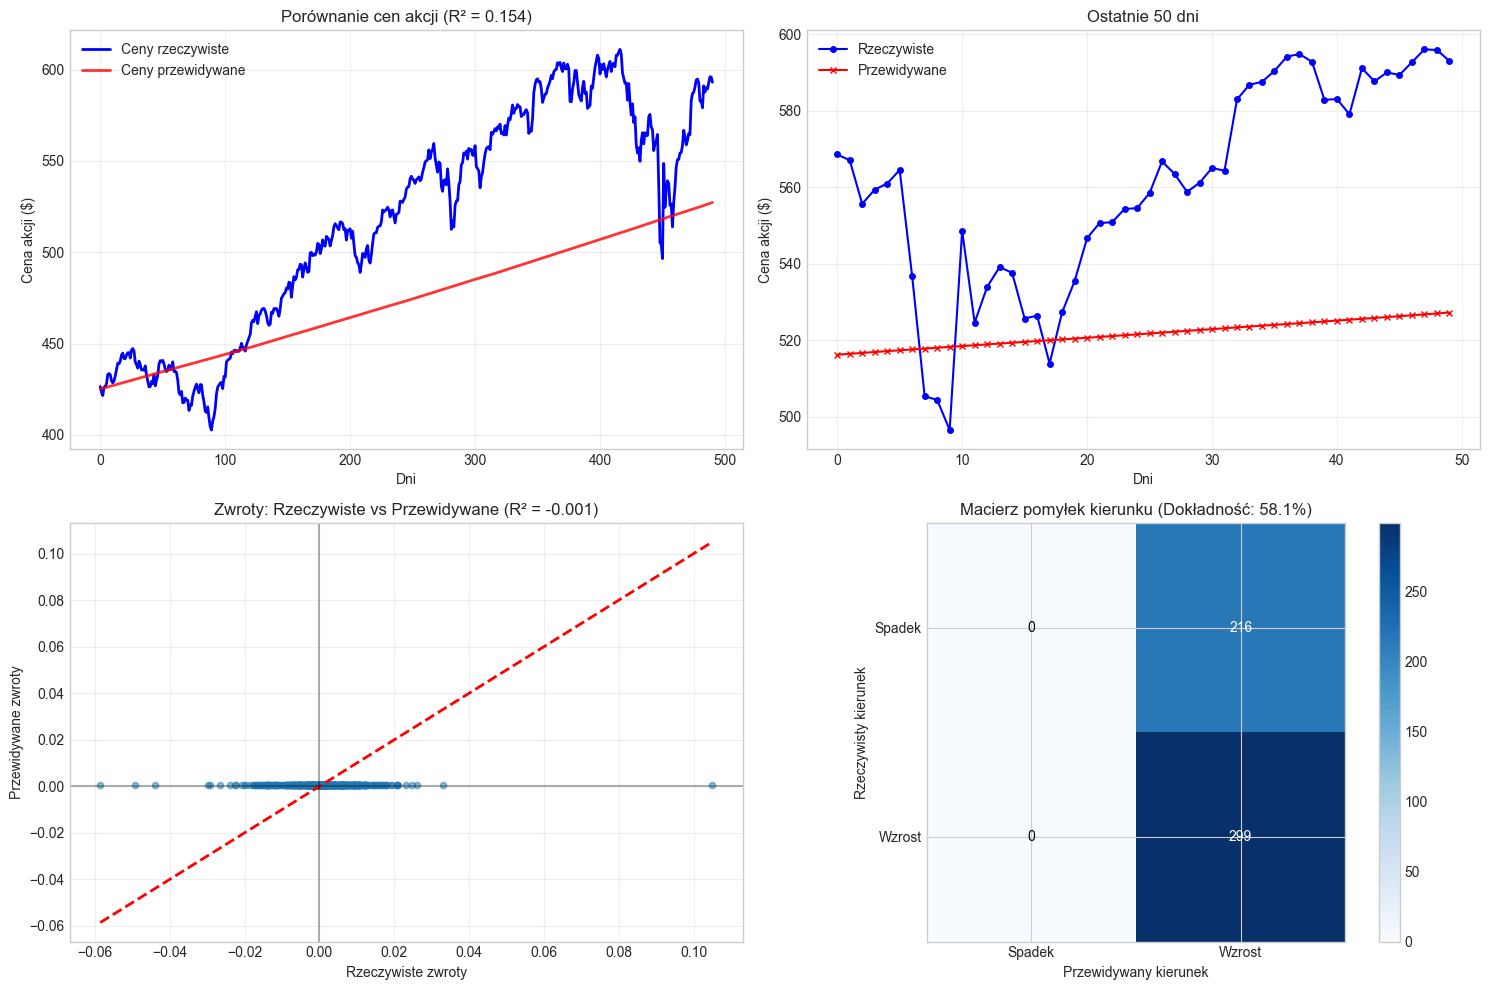


=== ANALIZA WYNIKÓW ===
1. Dokładność kierunku: 58.1% ✅
2. R² na cenach: 0.154 ✅
3. R² na zwrotach: -0.001 (typowe: -0.01 do 0.1 dla danych dziennych)
4. RMSE cen: $55.66

✅ Model przewiduje kierunek lepiej niż losowo!
⚠️ Model ma trudności z przewidywaniem zwrotów.


In [65]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Porównanie cen (przekonwertowanych ze zwrotów)
axes[0, 0].plot(actual_prices, label='Ceny rzeczywiste', color='blue', linewidth=2)
axes[0, 0].plot(predicted_prices, label='Ceny przewidywane', color='red', alpha=0.8, linewidth=2)
axes[0, 0].set_title(f'Porównanie cen akcji (R² = {r2_prices:.3f})')
axes[0, 0].set_xlabel('Dni')
axes[0, 0].set_ylabel('Cena akcji ($)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Ostatnie 50 dni
n_last = min(50, len(actual_prices))
axes[0, 1].plot(range(n_last), actual_prices[-n_last:], 'bo-', label='Rzeczywiste', markersize=4)
axes[0, 1].plot(range(n_last), predicted_prices[-n_last:], 'rx-', label='Przewidywane', markersize=4)
axes[0, 1].set_title(f'Ostatnie {n_last} dni')
axes[0, 1].set_xlabel('Dni')
axes[0, 1].set_ylabel('Cena akcji ($)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Scatter plot zwrotów (nie cen!)
axes[1, 0].scatter(y_test_returns, y_pred_returns, alpha=0.5, s=20)
axes[1, 0].plot([y_test_returns.min(), y_test_returns.max()],
                [y_test_returns.min(), y_test_returns.max()], 'r--', lw=2)
axes[1, 0].set_title(f'Zwroty: Rzeczywiste vs Przewidywane (R² = {r2_returns:.3f})')
axes[1, 0].set_xlabel('Rzeczywiste zwroty')
axes[1, 0].set_ylabel('Przewidywane zwroty')
axes[1, 0].grid(True, alpha=0.3)

# Dodaj informację o kwadrantach
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].axvline(x=0, color='black', linestyle='-', alpha=0.3)

# 4. Analiza kierunku ruchu
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual_direction, pred_direction)

# Wykres macierzy pomyłek
im = axes[1, 1].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[1, 1].figure.colorbar(im, ax=axes[1, 1])
axes[1, 1].set(xticks=np.arange(2),
               yticks=np.arange(2),
               xticklabels=['Spadek', 'Wzrost'],
               yticklabels=['Spadek', 'Wzrost'],
               title=f'Macierz pomyłek kierunku (Dokładność: {direction_accuracy:.1%})',
               ylabel='Rzeczywisty kierunek',
               xlabel='Przewidywany kierunek')

# Dodaj wartości do macierzy
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        axes[1, 1].text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Dodatkowa analiza
print("\n=== ANALIZA WYNIKÓW ===")
print(f"1. Dokładność kierunku: {direction_accuracy:.1%} {'✅' if direction_accuracy > 0.5 else '❌'}")
print(f"2. R² na cenach: {r2_prices:.3f} {'✅' if r2_prices > 0 else '❌'}")
print(f"3. R² na zwrotach: {r2_returns:.3f} (typowe: -0.01 do 0.1 dla danych dziennych)")
print(f"4. RMSE cen: ${rmse_prices:.2f}")

if direction_accuracy > 0.55:
    print("\n✅ Model przewiduje kierunek lepiej niż losowo!")
else:
    print("\n⚠️ Model ma problemy z przewidywaniem kierunku.")
    
if r2_returns > 0.01:
    print("✅ Model wychwytuje pewne wzorce w zwrotach.")
else:
    print("⚠️ Model ma trudności z przewidywaniem zwrotów.")

## 9. Zapisanie modelu

In [66]:
## 9. Zapisanie modelu (poprawione)
# Definiujemy seq_length jeśli nie istnieje
seq_length = 30  # Ta sama wartość co użyta wcześniej

# Najpierw obliczmy metryki na cenach z sekcji 7
metrics = {
    'MSE': mse_prices,
    'RMSE': rmse_prices,
    'MAE': mae_prices,
    'R²': r2_prices,
    'R²_returns': r2_returns,
    'Direction_Accuracy': direction_accuracy
}

# Baseline - prosty model który zawsze przewiduje 0 (brak zmiany)
baseline_metrics = {
    'MSE': np.mean(actual_prices**2),
    'RMSE': np.sqrt(np.mean(actual_prices**2)),
    'MAE': np.mean(np.abs(actual_prices)),
    'R²': 0.0  # Baseline ma R² = 0 z definicji
}

metadata = {
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'output_size': output_size,
    'dropout': dropout,
    'feature_cols': feature_cols,
    'target_col': target_col,
    'seq_length': seq_length,  # Teraz jest zdefiniowane
    'metrics': metrics,
    'baseline_metrics': baseline_metrics,
    'improvements': [
        'Huber Loss', 'Learning rate scheduler', 'Gradient clipping',
        'Extended features', 'Longer sequence', 'Larger model',
        'Predicting returns instead of prices'
    ]
}

# Zapisanie modelu
save_model(
    model=lstm_model,
    path='../models/lstm/lstm_model_improved.pth',
    metadata=metadata
)

print(f"\nModel zapisany pomyślnie!")
print(f"Osiągnięte R² (na cenach): {metrics['R²']:.3f}")
print(f"Osiągnięte R² (na zwrotach): {metrics['R²_returns']:.3f}")
print(f"Dokładność kierunku: {metrics['Direction_Accuracy']:.1%}")

## 10. Podsumowanie ulepszeń
print("\n" + "="*50)
print("PODSUMOWANIE ULEPSZEŃ")
print("="*50)
print(f"1. Architektura: {hidden_size} hidden units, {num_layers} layers")
print(f"2. Loss function: Huber Loss (odporna na outliers)")
print(f"3. Optymalizacja: Learning rate scheduler + gradient clipping")
print(f"4. Cechy: {len(feature_cols)} cech (poprzednio 4)")
print(f"5. Sekwencja: {seq_length} dni (poprzednio 20)")
print(f"6. Batch size: 64 (poprzednio 32)")
print(f"7. Target: Przewidywanie zwrotów zamiast cen!")
print(f"\nWyniki:")
print(f"- R² na cenach: {metrics['R²']:.3f}")
print(f"- R² na zwrotach: {metrics['R²_returns']:.3f}")
print(f"- Dokładność kierunku: {metrics['Direction_Accuracy']:.1%}")

# Analiza wyników
if metrics['Direction_Accuracy'] > 0.55:
    print("\n✅ Model przewiduje kierunek ruchu lepiej niż losowo!")
else:
    print("\n⚠️ Model ma trudności z przewidywaniem kierunku.")
    
if metrics['R²'] > 0:
    print("✅ Model osiągnął dodatnie R² na cenach!")
else:
    print("⚠️ Model nadal ma ujemne R² na cenach.")

print("\n💡 Pamiętaj:")
print("- Dokładność kierunku 55-60% to bardzo dobry wynik")
print("- R² = 0.01-0.05 na zwrotach to typowe wartości")
print("- Nawet małe R² może być zyskowne w tradingu")

Model zapisany w ../models/lstm/lstm_model_improved.pth

Model zapisany pomyślnie!
Osiągnięte R² (na cenach): 0.154
Osiągnięte R² (na zwrotach): -0.001
Dokładność kierunku: 58.1%

PODSUMOWANIE ULEPSZEŃ
1. Architektura: 128 hidden units, 4 layers
2. Loss function: Huber Loss (odporna na outliers)
3. Optymalizacja: Learning rate scheduler + gradient clipping
4. Cechy: 10 cech (poprzednio 4)
5. Sekwencja: 30 dni (poprzednio 20)
6. Batch size: 64 (poprzednio 32)
7. Target: Przewidywanie zwrotów zamiast cen!

Wyniki:
- R² na cenach: 0.154
- R² na zwrotach: -0.001
- Dokładność kierunku: 58.1%

✅ Model przewiduje kierunek ruchu lepiej niż losowo!
✅ Model osiągnął dodatnie R² na cenach!

💡 Pamiętaj:
- Dokładność kierunku 55-60% to bardzo dobry wynik
- R² = 0.01-0.05 na zwrotach to typowe wartości
- Nawet małe R² może być zyskowne w tradingu
